
## IDA / EDA — Walmart M5 Sales, Prices, Calendar

**Files I’m using from `./data/`:** `calendar.csv`, `sales_train_validation.csv`, `sell_prices.csv` 

**Steps::**
1. Load and merge the sales, prices, and calendar
2. Check shape, types, and nulls so I know data quality
3. Look at quick stats for numbers vs categories
4. Scan for missingness and obvious outliers
5. Do a fast reality check on price ↔ sales
6. Sketch a preprocessing plan (encoding, scaling, imputation) with sample code
7. Optionally export a small clean slice I can use for app tests


In [1]:

# Imports & settings
import os, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.options.display.float_format = lambda x: f"{x:,.4f}"
warnings.filterwarnings("ignore")

DATA_DIR = Path("data")
REQ = ["calendar.csv","sales_train_validation.csv","sell_prices.csv"]
assert all((DATA_DIR/f).exists() for f in REQ), "Missing one or more required CSVs in ./data"


## Load & Merge 

In [2]:

# Load raw files
cal   = pd.read_csv(DATA_DIR/"calendar.csv")
sales = pd.read_csv(DATA_DIR/"sales_train_validation.csv")
prices= pd.read_csv(DATA_DIR/"sell_prices.csv")

# Wide (d_1..d_x) -> long
day_cols = [c for c in sales.columns if c.startswith("d_")]
id_cols  = [c for c in sales.columns if c not in day_cols]
sales_long = sales.melt(id_vars=id_cols, value_vars=day_cols, var_name="d", value_name="sales")

# Minimal calendar cols I actually use
cal_keep = ["d","date","wm_yr_wk","event_name_1","event_type_1","event_name_2","event_type_2","snap_CA","snap_TX","snap_WI"]
cal_trim = cal[cal_keep].copy()

# Merge calendar + prices
df = sales_long.merge(cal_trim, on="d", how="left")
df = df.merge(prices, on=["store_id","item_id","wm_yr_wk"], how="left")

# Parse date & sort
df["date"] = pd.to_datetime(df["date"])
df.sort_values(["store_id","item_id","date"], inplace=True)

# Fill price inside each (store,item) so I’m not losing rows
df["sell_price"] = df.groupby(["store_id","item_id"])["sell_price"].ffill().bfill()

# Row-level SNAP flag based on state
def snap_flag(row):
    if row["state_id"] == "CA": return row["snap_CA"]
    if row["state_id"] == "TX": return row["snap_TX"]
    if row["state_id"] == "WI": return row["snap_WI"]
    return 0
df["snap"] = df.apply(snap_flag, axis=1).fillna(0).astype(int)

# Keep the core columns I actually analyze
keep = ["date","wm_yr_wk","state_id","store_id","cat_id","dept_id","item_id",
        "sales","sell_price","event_name_1","event_type_1","event_name_2","event_type_2","snap"]
df = df[keep].copy()

df.head()


,date,wm_yr_wk,state_id,store_id,cat_id,dept_id,item_id,sales,sell_price,event_name_1,event_type_1,event_name_2,event_type_2,snap
1612,2011-01-29,11101,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,3,2.0000,NaN,NaN,NaN,NaN,0
32102,2011-01-30,11101,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,0,2.0000,NaN,NaN,NaN,NaN,0
62592,2011-01-31,11101,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,0,2.0000,NaN,NaN,NaN,NaN,0
93082,2011-02-01,11101,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,1,2.0000,NaN,NaN,NaN,NaN,1
123572,2011-02-02,11101,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,4,2.0000,NaN,NaN,NaN,NaN,1


## Quick Checks (how big, what span)

In [3]:

rows, cols = df.shape
start, end = df["date"].min(), df["date"].max()
print(f"Rows: {rows:,} | Cols: {cols}")
print(f"Date range: {start.date()} → {end.date()}")
print("Stores:", df["store_id"].nunique(), "| Items:", df["item_id"].nunique())


Rows: 58,327,370 | Cols: 14
Date range: 2011-01-29 → 2016-04-24
Stores: 10 | Items: 3049



## Structure & Descriptives (what I’m looking for)
I want to see dtypes, null counts, and quick stats so I know what’s usable right now and what needs cleanup. I separate numeric from categorical because `.describe()` means different things for each.


In [4]:

def info_table(data: pd.DataFrame) -> pd.DataFrame:
    non_null = data.notnull().sum()
    out = pd.DataFrame({
        "column": data.columns,
        "dtype": [str(t) for t in data.dtypes],
        "non_null": [int(non_null[c]) for c in data.columns],
        "nulls": [int(len(data)-non_null[c]) for c in data.columns]
    })
    out["null_pct"] = (out["nulls"]/len(data)).round(4)
    return out

info_df = info_table(df)
info_df


,column,dtype,non_null,nulls,null_pct
0,date,datetime64[ns],58327370,0,0.0000
1,wm_yr_wk,int64,58327370,0,0.0000
2,state_id,object,58327370,0,0.0000
3,store_id,object,58327370,0,0.0000
4,cat_id,object,58327370,0,0.0000
5,dept_id,object,58327370,0,0.0000
6,item_id,object,58327370,0,0.0000
7,sales,int64,58327370,0,0.0000
8,sell_price,float64,58327370,0,0.0000
9,event_name_1,object,4695460,53631910,0.9195


In [5]:

num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["number","datetime64[ns]"]).columns.tolist()

print("Numeric columns:")
display(pd.DataFrame({"col": num_cols}))
display(df[num_cols].describe().T.round(3))

print("\nCategorical columns:")
display(pd.DataFrame({"col": cat_cols}))
display(df[cat_cols].describe().T if cat_cols else pd.DataFrame())


Numeric columns:


,col
0,wm_yr_wk
1,sales
2,sell_price
3,snap


,count,mean,std,min,25%,50%,75%,max
wm_yr_wk,"58,327,370.0000","11,339.1910",150.3740,"11,101.0000","11,217.0000","11,333.0000","11,448.0000","11,613.0000"
sales,"58,327,370.0000",1.1260,3.8730,0.0000,0.0000,0.0000,1.0000,763.0000
sell_price,"58,327,370.0000",4.4460,3.5250,0.0100,2.1800,3.4200,5.8400,107.3200
snap,"58,327,370.0000",0.3290,0.4700,0.0000,0.0000,0.0000,1.0000,1.0000



Categorical columns:


,col
0,state_id
1,store_id
2,cat_id
3,dept_id
4,item_id
5,event_name_1
6,event_type_1
7,event_name_2
8,event_type_2


,count,unique,top,freq
state_id,58327370,3,CA,23330948
store_id,58327370,10,CA_1,5832737
cat_id,58327370,3,FOODS,27489810
dept_id,58327370,7,FOODS_3,15743990
item_id,58327370,3049,FOODS_1_001,19130
event_name_1,4695460,30,SuperBowl,182940
event_type_1,4695460,4,Religious,1585480
event_name_2,121960,4,Easter,30490
event_type_2,121960,2,Cultural,91470



## Missingness 
Checking the null fraction by column and a quick heatmap-ish view (sampled) just to see if missingness is random or patterned (for example, long runs of missing prices for certain items).


In [6]:

null_frac = df.isnull().mean().sort_values(ascending=False).reset_index()
null_frac.columns = ["column","null_fraction"]
null_frac.head(20)


,column,null_fraction
0,event_name_2,0.9979
1,event_type_2,0.9979
2,event_name_1,0.9195
3,event_type_1,0.9195
4,date,0.0000
5,wm_yr_wk,0.0000
6,state_id,0.0000
7,store_id,0.0000
8,cat_id,0.0000
9,dept_id,0.0000


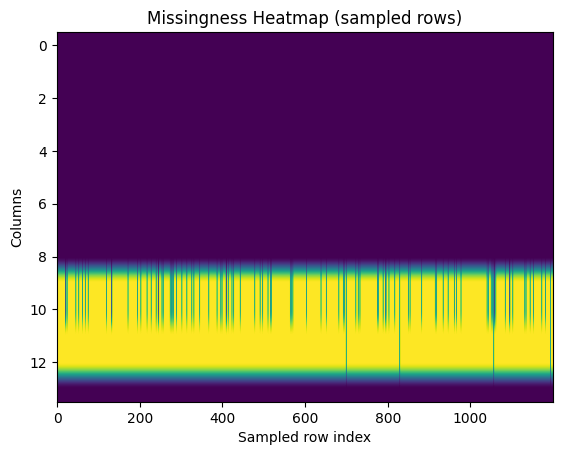

In [7]:

import matplotlib.pyplot as plt

sample_n = min(1200, len(df))
sample_mat = df.sample(sample_n, random_state=42).isnull().astype(int)

plt.figure()
plt.imshow(sample_mat.T, aspect="auto")
plt.title("Missingness Heatmap (sampled rows)")
plt.xlabel("Sampled row index")
plt.ylabel("Columns")
plt.show()



## Outliers (z-score)
This is a quick scan for extreme values (|z| > 3).


In [8]:

from scipy.stats import zscore
outlier_counts = {}
for col in num_cols:
    s = df[col].dropna()
    if s.empty:
        outlier_counts[col] = 0
        continue
    z = zscore(s.to_numpy())
    outlier_counts[col] = int((np.abs(z) > 3).sum())

pd.DataFrame({"column": list(outlier_counts.keys()), "outliers_|z|>3": list(outlier_counts.values())}).sort_values("outliers_|z|>3", ascending=False)


,column,outliers_|z|>3
2,sell_price,1018783
1,sales,789493
0,wm_yr_wk,0
3,snap,0



## Price vs Sales
There is a negative (inverse) relationship: as price goes up, units usually drop (not always, but generally). I use Spearman here because it’s more forgiving if the relationship isn’t perfectly linear.


In [9]:

corr = df[["sell_price","sales"]].dropna().corr(method="spearman")
corr


,sell_price,sales
sell_price,1.0000,-0.1721
sales,-0.1721,1.0000



## My Preprocessing Plan 
- **Encoding:** Turn `state_id`, `store_id`, `cat_id`, `dept_id`, `item_id`, `event_type_1` into category codes so models and joins are fast and clean.  
- **Scaling:** Standardize (z-score) only where it matters (e.g., multi-feature regressions). Time-series plots and group summaries don’t need it.  
- **Imputation:**  
  - Numeric (like `sell_price`): forward/backfill within (store,item), then median by item if there’s still a hole.  
  - Categorical (like event types): fill with mode or `Unknown` so I don’t drop rows by accident.  


In [10]:

work = df.copy()

# If anything is still missing in price after ffill/bfill, fill with item-level median
med_price = work.groupby("item_id")["sell_price"].transform(lambda s: s.fillna(s.median()))
work["sell_price_imp"] = work["sell_price"].fillna(med_price)

# Category encodings I can reuse later
for c in ["state_id","store_id","cat_id","dept_id","item_id","event_type_1"]:
    work[c] = work[c].astype("category")
    work[f"{c}_code"] = work[c].cat.codes

# Example standardization: within each (store,item), how “high” or “low” were today’s sales vs that series
from scipy.stats import zscore
work["sales_z"] = work.groupby(["store_id","item_id"])["sales"].transform(lambda s: (s - s.mean())/(s.std(ddof=0) + 1e-9))

work.head()


,date,wm_yr_wk,state_id,store_id,cat_id,dept_id,item_id,sales,sell_price,event_name_1,event_type_1,event_name_2,event_type_2,snap,sell_price_imp,state_id_code,store_id_code,cat_id_code,dept_id_code,item_id_code,event_type_1_code,sales_z
1612,2011-01-29,11101,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,3,2.0000,NaN,NaN,NaN,NaN,0,2.0000,0,0,0,0,0,-1,1.7606
32102,2011-01-30,11101,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,0,2.0000,NaN,NaN,NaN,NaN,0,2.0000,0,0,0,0,0,-1,-0.6247
62592,2011-01-31,11101,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,0,2.0000,NaN,NaN,NaN,NaN,0,2.0000,0,0,0,0,0,-1,-0.6247
93082,2011-02-01,11101,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,1,2.0000,NaN,NaN,NaN,NaN,1,2.0000,0,0,0,0,0,-1,0.1704
123572,2011-02-02,11101,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,4,2.0000,NaN,NaN,NaN,NaN,1,2.0000,0,0,0,0,0,-1,2.5557
